In [2]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('earthquakes.csv')
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2017-01-01 23:59:10,37.085500,-98.040667,6.36,1.56,ml,12.0,137.00,0.05775,0.0400,...,2017-03-02 15:40:54,"7km S of Anthony, Kansas",earthquake,0.19,0.61,0.128,13.0,reviewed,ismp,ismp
1,2017-01-01 23:50:58,62.798800,-149.467300,6.00,0.90,ml,NaN,NaN,NaN,0.6300,...,2017-01-06 02:34:10,"62km NNE of Talkeetna, Alaska",earthquake,NaN,0.40,NaN,NaN,reviewed,ak,ak
2,2017-01-01 23:50:39,32.966833,-115.562833,9.88,2.56,ml,47.0,75.00,0.06521,0.2400,...,2017-02-08 19:29:28,"3km WSW of Brawley, CA",earthquake,0.21,0.52,0.236,24.0,reviewed,ci,ci
3,2017-01-01 23:50:07,38.428400,-118.889200,5.50,1.20,ml,6.0,210.16,0.07200,0.0885,...,2017-03-14 05:05:00,"25km WSW of Hawthorne, Nevada",earthquake,NaN,7.90,0.250,2.0,reviewed,nn,nn
4,2017-01-01 23:47:17,38.428400,-118.901300,6.70,1.90,ml,13.0,70.02,0.07200,0.1497,...,2017-03-14 05:05:02,"26km WSW of Hawthorne, Nevada",earthquake,NaN,1.90,0.250,8.0,reviewed,nn,nn


First of all, lets explore what is inside the dataframe

In [4]:
df.describe()

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
count,126955.000000,126955.000000,126955.000000,126939.000000,71375.000000,89008.000000,87871.000000,126906.000000,76397.000000,126910.000000,85675.000000,86895.000000
mean,40.486765,-111.887759,25.440290,1.599419,18.168771,128.741924,0.646571,0.316791,2.289327,3.201101,0.175648,17.069705
std,19.864389,67.890203,58.042815,1.237212,15.108856,70.423981,2.481635,0.292301,3.730611,39.591751,0.126807,31.039435
min,-64.992600,-179.995300,-3.470000,-9.990000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.639333,-148.994850,3.700000,0.790000,8.000000,75.000000,0.027560,0.091600,0.280000,0.400000,0.098000,4.000000
50%,38.787833,-119.025500,8.600000,1.300000,14.000000,113.000000,0.073360,0.190000,0.500000,0.800000,0.152000,9.000000
75%,57.827050,-116.473000,17.300000,2.000000,23.000000,168.000000,0.261000,0.490000,2.160000,2.190000,0.225000,19.000000
max,86.996400,179.997000,664.030000,8.200000,259.000000,359.000000,141.160000,4.070000,98.990000,8713.400000,5.080000,941.000000


In [5]:
df.dtypes

time                object
latitude           float64
longitude          float64
depth              float64
mag                float64
magType             object
nst                float64
gap                float64
dmin               float64
rms                float64
net                 object
id                  object
updated             object
place               object
type                object
horizontalError    float64
depthError         float64
magError           float64
magNst             float64
status              object
locationSource      object
magSource           object
dtype: object

As we are working with earthquakes, the most critical part is how often and where they occurred. Let's show all the shocks and their frequency on a map. 

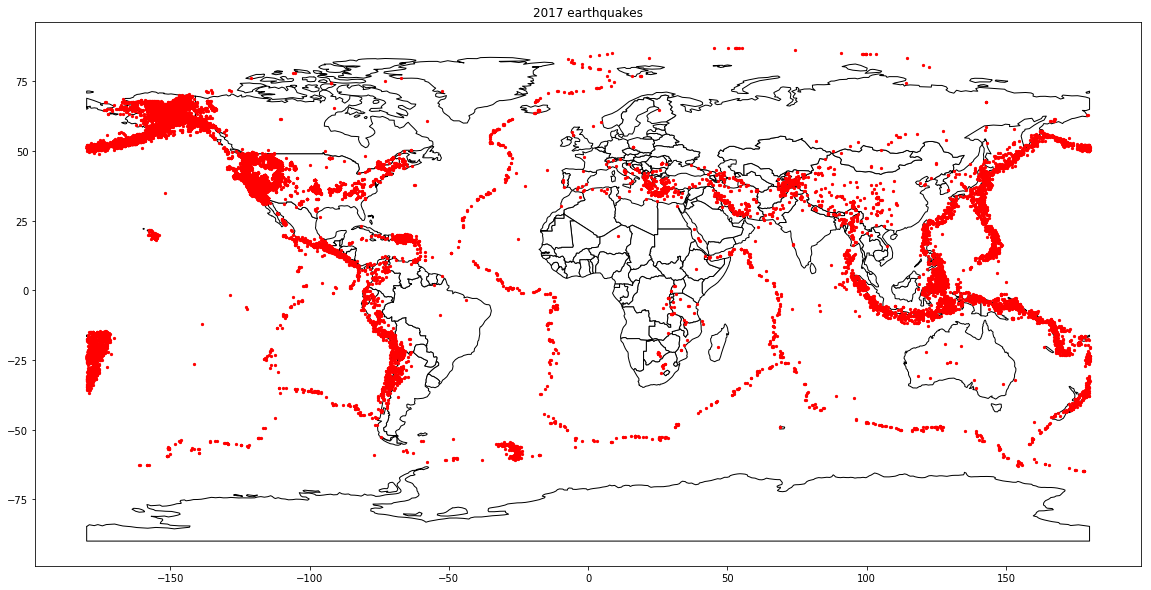

In [13]:
import geopandas as gpd
import numpy as np
from scipy import ndimage

import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

from geopandas import GeoDataFrame
from shapely.geometry import Point

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# world.plot()

geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
geo_df = df.drop(['latitude', 'longitude'], axis=1)
qgdf = GeoDataFrame(df, crs=geo_df, geometry=geometry)
# gdf.plot()
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_aspect('equal')
world.plot(ax=ax, color='white', edgecolor='black')
qgdf.plot(ax=ax, marker='o', color='red', markersize=5)
plt.title('2017 earthquakes')

plt.show();

So, we can observe clear regions with high activity. This map is helpful to see the regional distribution of earthquakes, but it says nothing about their magnitude and time when they occurred.

So let's firstly build a histogram which would show monthly data for earthquakes and maybe there is some more active month than all others. Also, it might be nice to learn about where data come from, so we could build the distribution of data sources 

The following code is showing the number of earthquakes grouped by month. As we can see they are not equally distributed, but we can not make any conclusions as we have the data only for one year We could try to find some correlation between month or season and number of earthquakes if we have data for many years.
Therefore, this is the dead end in the current case, and we are not going to continue this exploration

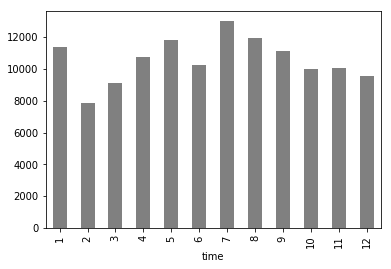

In [14]:
df["time"] = df["time"].astype("datetime64[ns]")
df.groupby(df["time"].dt.month).count()['id'].plot(kind='bar', color='gray')

The map above could be handy to observe the full picture, but it is too noisy. Depending on a particular case we could be interested in small or large earthquakes. For general purpose, let discover where the larges shocks were and how are they distributed.

First of all, let's explore magnitude. In order to sort by mag we need it to be of the in the same units of measurement.

In [15]:
qgdf['mag'].describe()

count    126939.000000
mean          1.599419
std           1.237212
min          -9.990000
25%           0.790000
50%           1.300000
75%           2.000000
max           8.200000
Name: mag, dtype: float64

In [16]:
qgdf['magType'].describe()

count     126939
unique        14
top           ml
freq       79764
Name: magType, dtype: object

In [17]:
qgdf['magType'].unique()

array(['ml', 'mb', 'md', 'Md', 'mb_lg', 'mwb', 'mwr', 'mww', 'Mb', nan,
       'mh', 'mw', 'Ml', 'mlg', 'ms_20'], dtype=object)

As the aggregations above suggest, we have 14 different magnitude types, and for each class we are going to have a different scale, so there is no reasonable way to build a single map with deadliest earthquakes, therefore we could first make the distribution of earthquakes by type and then, find the deadliest ones for each class. 

In [18]:
qgdf.groupby(df["magType"]).count()['mag']

magType
Mb           1
Md        1032
Ml           3
mb       11933
mb_lg      386
md       32198
mh          44
ml       79764
mlg          2
ms_20        1
mw          78
mwb         20
mwr        677
mww        800
Name: mag, dtype: int64

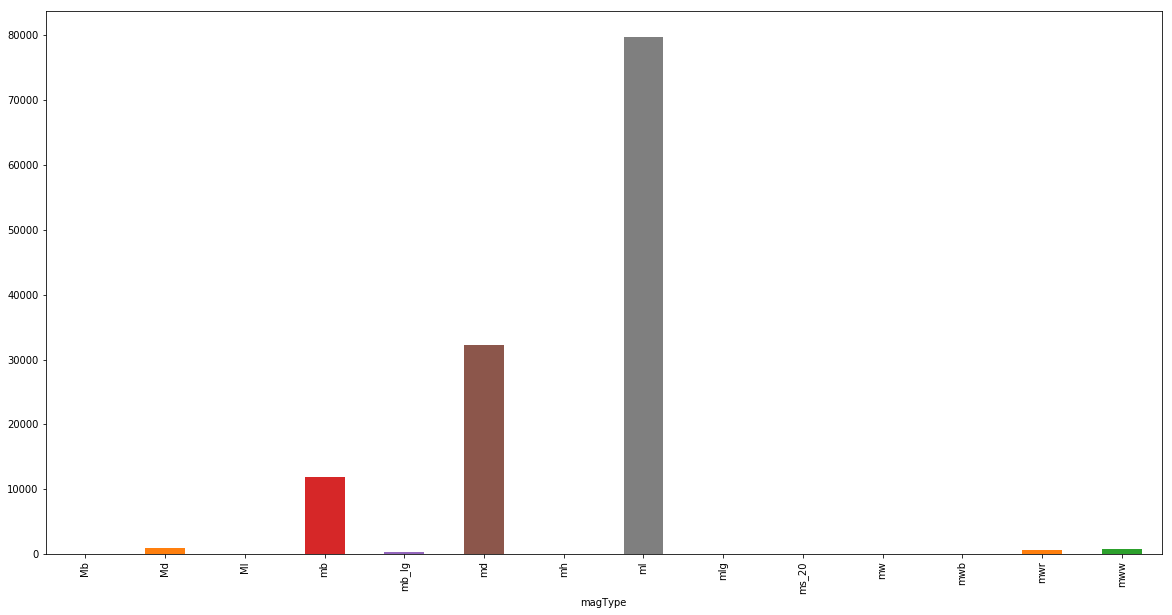

In [19]:
qgdf.groupby(qgdf["magType"]).count()['mag'].plot(kind='bar', figsize=(20, 10))

As we can see most frequent scales are ml, md, and mb. But they could be in lower and upper case, so let's remove that inconsistency

In [20]:
qgdf['magType'] = qgdf['magType'].apply(lambda x: str(x).lower())
qgdf.groupby(qgdf["magType"]).count()['mag']

magType
mb       11934
mb_lg      386
md       33230
mh          44
ml       79767
mlg          2
ms_20        1
mw          78
mwb         20
mwr        677
mww        800
nan          0
Name: mag, dtype: int64

Let's try to normalize magnitude for some type and visualize the largest earthquakes. For now, we could choose ml

In [21]:
ml_mag_df = qgdf.loc[qgdf['magType'] == 'ml']
ml_mag_df = ml_mag_df.loc[ml_mag_df['mag'] > 0]
ml_mag_df['mag'].describe()
ml_mag_df_copy = ml_mag_df.loc[qgdf['magType'] == 'ml']

In [22]:
ml_min = np.min(ml_mag_df['mag'])
ml_max = np.max(ml_mag_df['mag'])
ml_mag_df['mag'] = ml_mag_df['mag'].apply(lambda x: (x - ml_min) / (ml_max - ml_min))
ml_mag_df['mag'].describe()

count    77684.000000
mean         0.243232
std          0.131550
min          0.000000
25%          0.143898
50%          0.231330
75%          0.322404
max          1.000000
Name: mag, dtype: float64

Let's visualize the few largest and smallest earthquakes with ml magnitude for comparison. 
On the map below, we could observe one strongest(red) and weakest(black) ml earthquake in contrast.

Text(0.5,1,'largest and smalest ml')

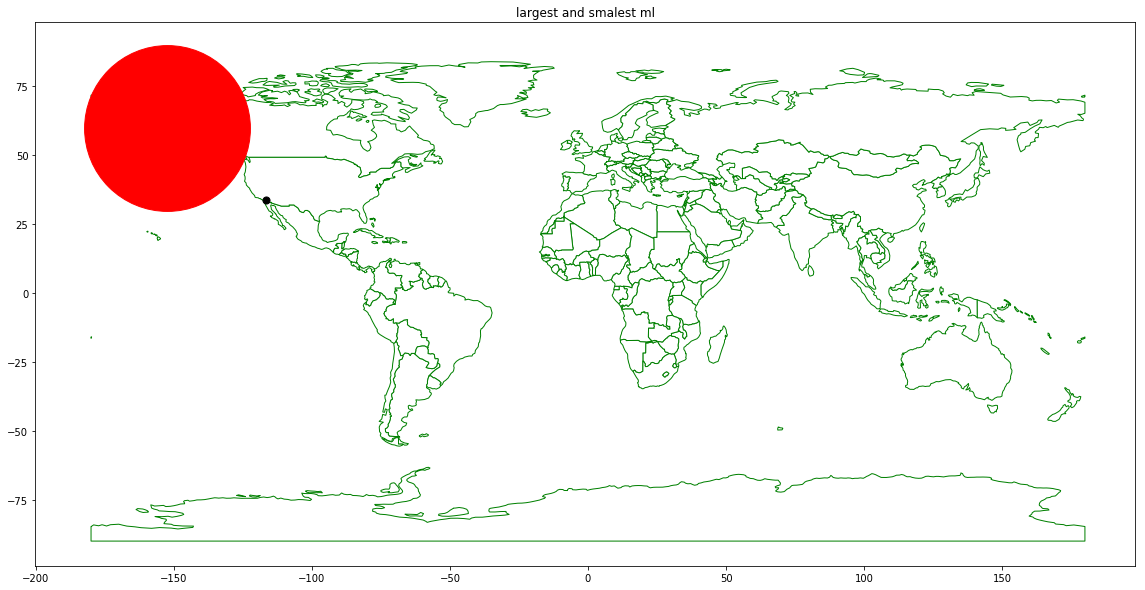

In [26]:
sorted_ml_df = ml_mag_df_copy.sort_values(by=['mag'], ascending=False)

fig, ax = plt.subplots(figsize=(20, 10))
ax.set_aspect('equal')
world.plot(ax=ax, color='white', edgecolor='green')

sorted_ml_df.geometry.iloc[0:1].plot(ax = ax, markersize = sorted_ml_df['mag'].iloc[0] * 5000, color='red', marker='o')
sorted_ml_df.geometry.iloc[-2:-1].plot(ax = ax, markersize = sorted_ml_df['mag'].iloc[-1] * 5000, color='black', marker='o')
plt.title('largest and smalest ml')


Now let's show one hundred strongest earthquakes
As can be observed on the map below deadliest earthquakes are in Alaska

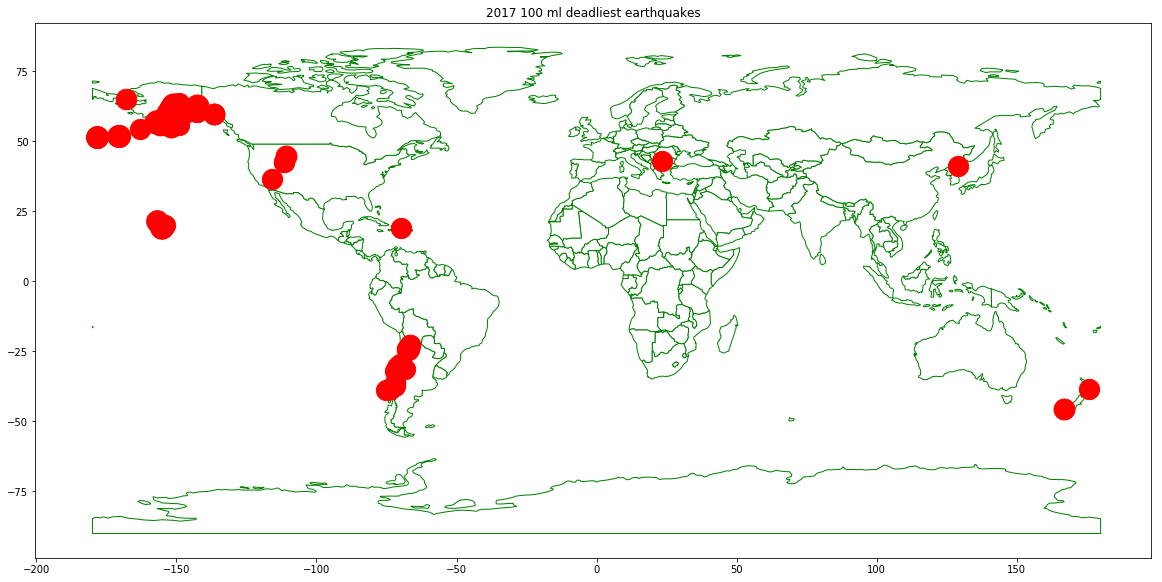

In [27]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_aspect('equal')
plt.title('2017 100 ml deadliest earthquakes')
base = world.plot(ax=ax, color='white', edgecolor='green')
for i in range(0, 100):
    sorted_ml_df.geometry.iloc[i:i+1].plot(ax = ax, markersize = sorted_ml_df['mag'].iloc[i] * 100, color='red', marker='o')

Although, shockes in Alaska are largest, there are not so many people living there, so 
Also, as far as I'm concerned, we are interested, which cities are most indanger from earthquakes, therefore let's visualize worlds largest cities along with deadliest earthquakes

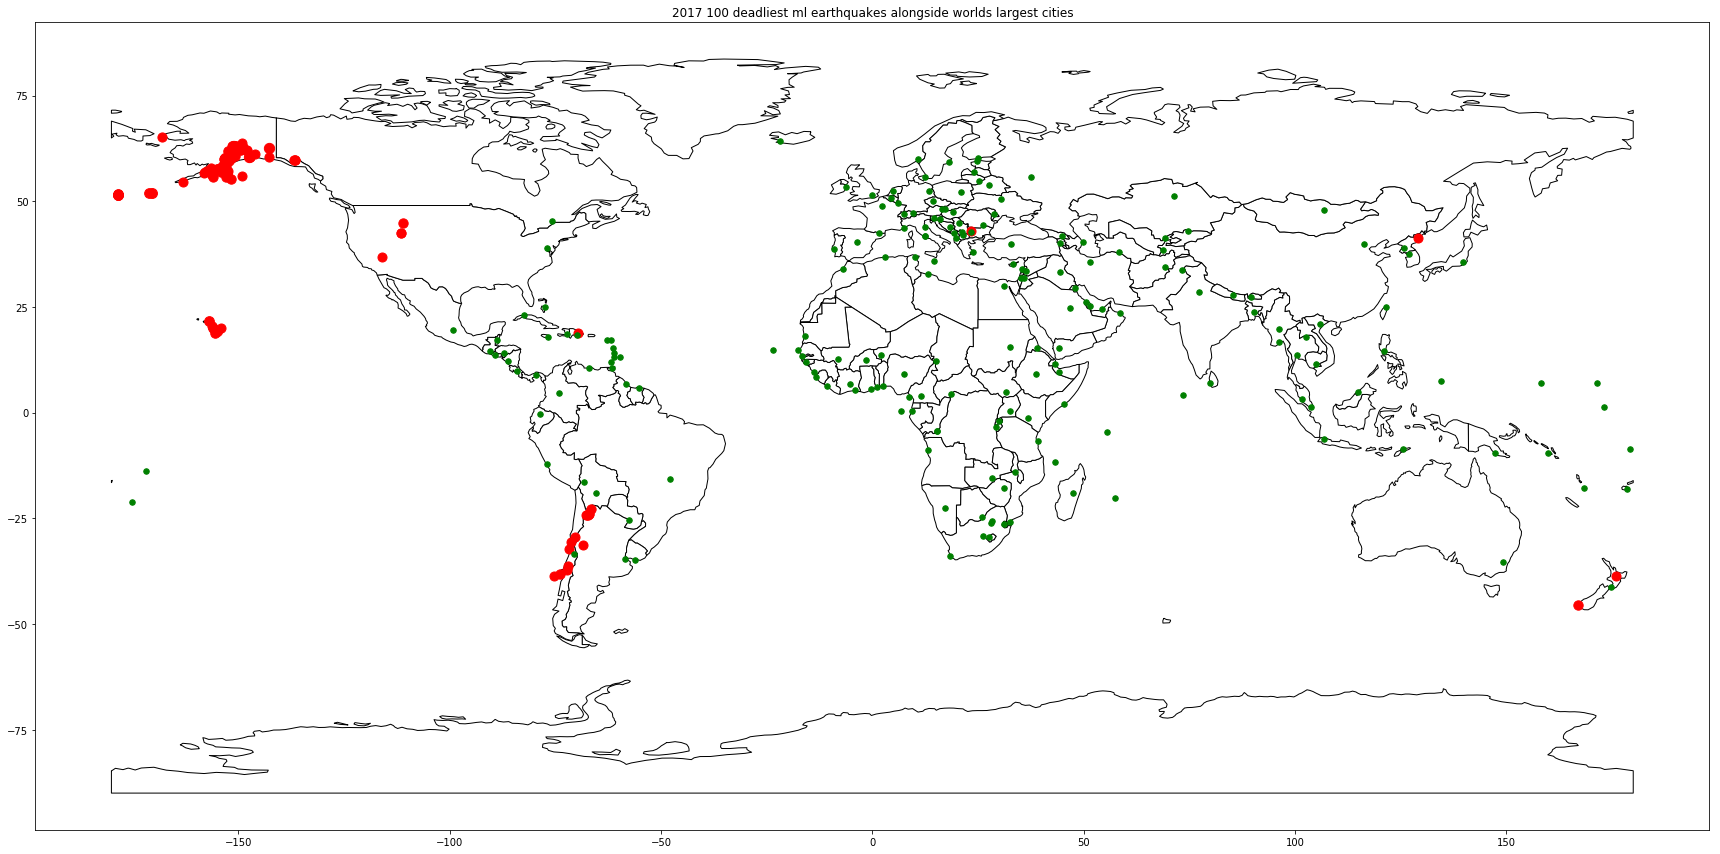

In [28]:
#world_by_countries = world[['state', 'geometry', 'pop_est']]
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
# countries = world[['geometry', 'name', 'pop_est']]
# countries = world.dissolve(by='name', aggfunc='sum')

fig, ax = plt.subplots(figsize=(30, 15))
ax.set_aspect('equal')
plt.title('2017 100 deadliest ml earthquakes alongside worlds largest cities')
base = world.plot(ax=ax, color='white', edgecolor='black')
for i in range(0, 100):
    sorted_ml_df.geometry.iloc[i:i+1].plot(ax = ax, markersize = sorted_ml_df['mag'].iloc[i] * 20, color='red', marker='o')
cities.plot(ax = base, marker='o', color='green', markersize=30);


The plot above alows us to see which cities are most indanger from earthquakes

Let's now discover where the data is comming from using magSource and locationSource


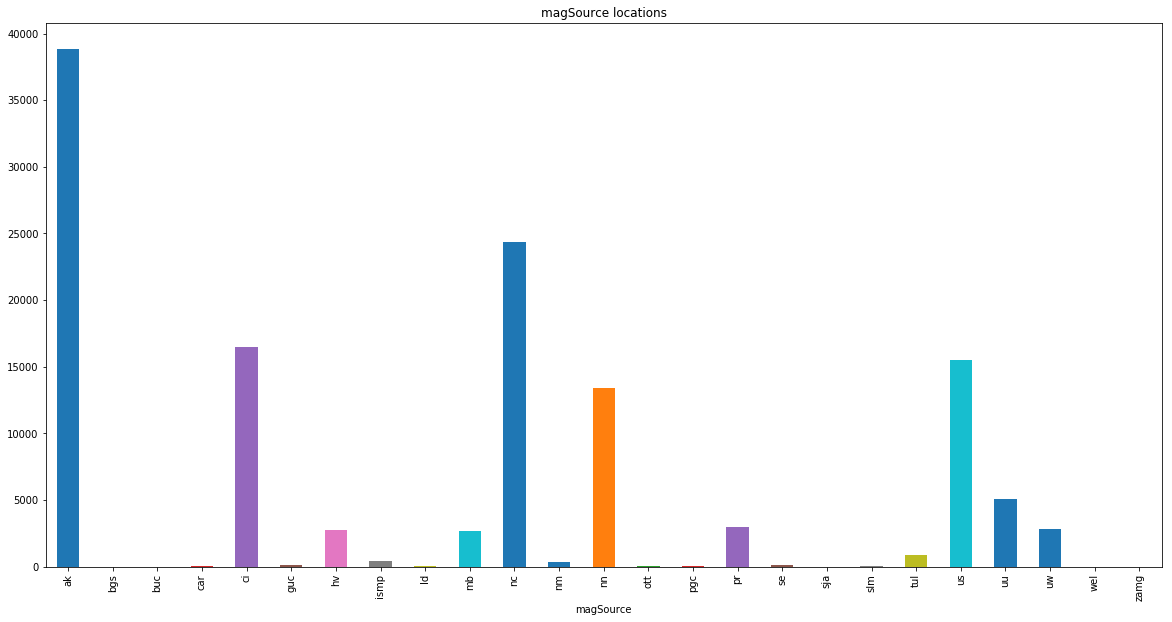

In [36]:
qgdf.groupby(qgdf["magSource"]).count()['mag'].plot(kind='bar', figsize=(20, 10), title='magSource locations')

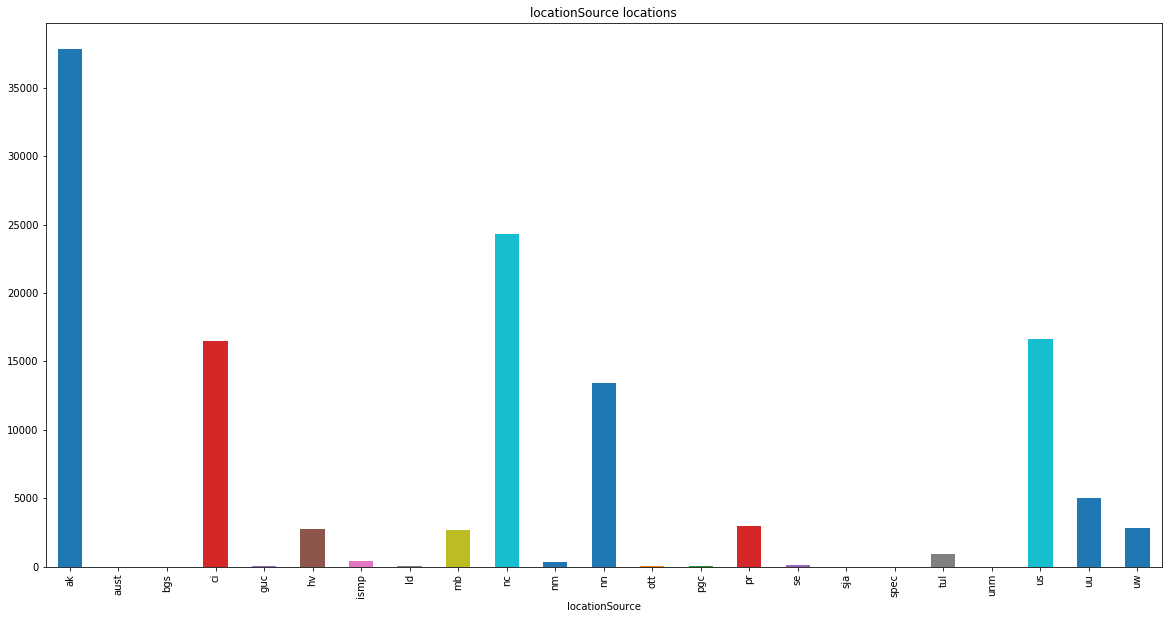

In [37]:
qgdf.groupby(qgdf["locationSource"]).count()['mag'].plot(kind='bar', figsize=(20, 10), title='locationSource locations')

So, as we can see the distribution is roughly  the same with ak and nc as main data sources

And finally, let's investigate errors distribution 

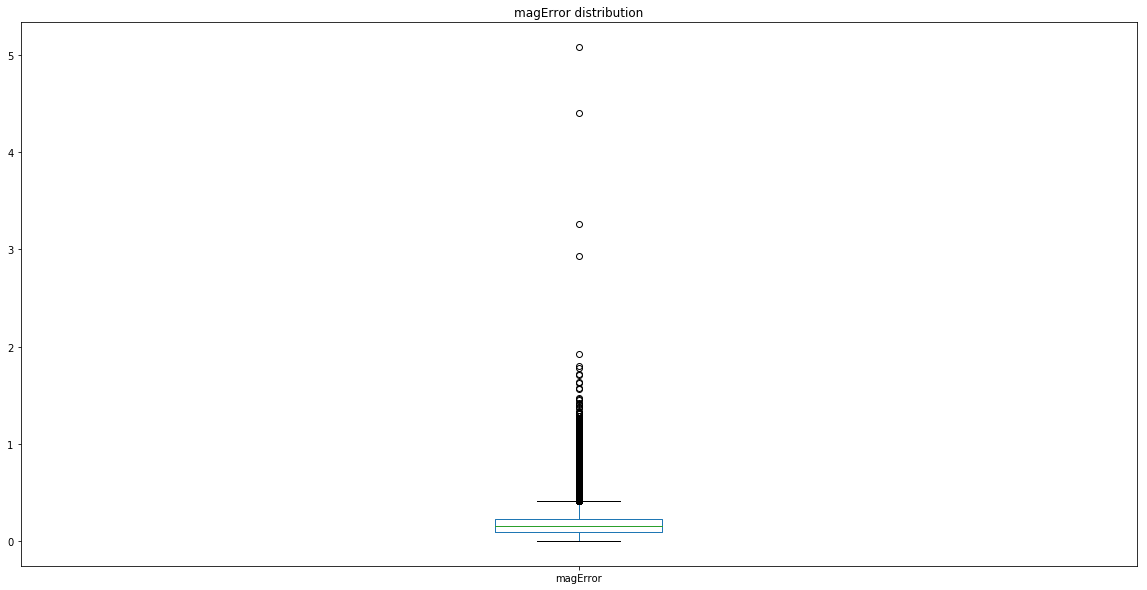

In [42]:
qgdf["magError"].plot(kind='box', figsize=(20, 10), title='magError distribution')